# Script Set Up

In [1]:
%matplotlib inline

In [2]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 19.9 MB/s eta 0:00:00


In [3]:
!pip install pingouin
import pingouin as pg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=a5ff0f55f4049c949acf977d9fcd6ad320a32b0ca0c5bc5b65316cf932522744
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [4]:
!pip install dataframe-image
import dataframe_image as dfi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.5/398.5 kB 25.6 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import mne

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Deciding what response times are outliers that should be removed

In [7]:
lower_RT_cutoff = 150
upper_RT_cutoff = 1500 # 1.5x longest SI and is less than 1% of trials

# Load Epochs
Load each participant's epochs

In [8]:
ID_list = ['P1', 'P3', 'P4', 'P7', 'P10', 'P12', 'P15', 'P17', 'P19', 'P21', 'P22', 'P23', 'P24',
           'P26', 'P27', 'P28', 'P29', 'P30']

n_participants = len(ID_list)
n_channels_evoked = 128
n_channels_epochs = 145
n_times_encode = 717
n_times_repo = 616
n_times_RL = 615

sample_rate = 512

encode_epochs = []
encode_metadata = []
repo_epochs = []
repo_metadata = []
RL_epochs = []
RL_metadata = []

all_encode_evokeds = np.zeros([len(ID_list), n_channels_evoked, n_times_encode])
all_repo_evokeds = np.zeros([len(ID_list), n_channels_evoked, n_times_repo])
all_RL_evokeds = np.zeros([len(ID_list), n_channels_evoked, n_times_RL])

i = -1

for ID in ID_list:
  i += 1
  encode_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/" + ID + "_Encode_All_CSD_epo.fif"
  repo_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/" + ID + "_Reproduction_All_CSD_epo.fif"
  RL_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/" + ID + "_RL_All_CSD_epo.fif"

  encode_epochs_participant = mne.read_epochs(encode_fname, preload = False)
  repo_epochs_participant = mne.read_epochs(repo_fname, preload = False)
  RL_epochs_participant = mne.read_epochs(RL_fname, preload = False)

  encode_epochs_participant.load_data()
  repo_epochs_participant.load_data()
  RL_epochs_participant.load_data()

  info = encode_epochs_participant.info

  ## REMOVING OUTLIER RTs # 04/01/23
  encode_indices = encode_epochs_participant.metadata.query("Response_Time > 150 & Response_Time < 1500").index # get trials for that condition
  repo_indices = repo_epochs_participant.metadata.query("Response_Time > 150 & Response_Time < 1500").index
  RL_indices = RL_epochs_participant.metadata.query("Response_Time > 150 & Response_Time < 1500").index

  encode_epochs_participant = encode_epochs_participant[encode_indices]
  repo_epochs_participant = repo_epochs_participant[repo_indices]
  RL_epochs_participant = RL_epochs_participant[RL_indices]

  # Adding ID column to metadata 19/12/22
  encode_df = encode_epochs_participant.metadata
  encode_df["ID"] = ID # adding ID column
  temp_cols=encode_df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  encode_df=encode_df[new_cols]
  encode_metadata.append(encode_df)

  repo_df = repo_epochs_participant.metadata
  repo_df["ID"] = ID # adding ID column
  temp_cols=repo_df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  repo_df=repo_df[new_cols]
  repo_metadata.append(repo_df)

  RL_df = RL_epochs_participant.metadata
  RL_df["ID"] = ID # adding ID column
  temp_cols=RL_df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  RL_df=RL_df[new_cols]
  RL_metadata.append(RL_df)

  ## Evoked ##
  all_encode_evokeds[i] = encode_epochs_participant.average().data
  all_repo_evokeds[i] = repo_epochs_participant.average().data
  all_RL_evokeds[i] = RL_epochs_participant.average().data

Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P1_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
775 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P1_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P1_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 proje

# Concatenate Metadata
Concatenate metadata so that all participants epochs are in one array


In [9]:
encode_metadata = pd.concat(encode_metadata, ignore_index = True)
encode_metadata

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,0,851.562500,0.0,1026.308594,1013.867188,56,431.640625,0.0,1283.203125,0.0
1,P1,1,865.234375,0.0,997.128906,981.640625,53,402.343750,0.0,1267.578125,1.0
2,P1,3,861.328125,0.0,1038.046875,1029.492188,58,373.046875,0.0,1234.375000,1.0
3,P1,4,914.062500,0.0,1013.515625,1011.914062,55,437.500000,0.0,1351.562500,0.0
4,P1,5,880.859375,0.0,945.742188,942.578125,51,437.500000,0.0,1318.359375,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13487,P30,894,1197.265625,1.0,1159.707031,1137.890625,59,402.343750,0.0,1599.609375,0.0
13488,P30,895,923.828125,1.0,884.492188,860.546875,51,443.359375,0.0,1367.187500,0.0
13489,P30,896,912.109375,1.0,892.343750,874.218750,52,355.468750,0.0,1267.578125,0.0
13490,P30,897,1107.421875,1.0,1109.980469,1095.898438,58,443.359375,0.0,1550.781250,0.0


In [10]:
repo_metadata = pd.concat(repo_metadata, ignore_index = True)
repo_metadata

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,0,851.562500,0.0,1026.308594,1013.867188,156,431.640625,0.0,1283.203125,0.0
1,P1,4,914.062500,0.0,1013.515625,1011.914062,155,437.500000,0.0,1351.562500,0.0
2,P1,5,880.859375,0.0,945.742188,942.578125,151,437.500000,0.0,1318.359375,0.0
3,P1,6,742.187500,0.0,980.234375,965.039062,152,390.625000,0.0,1132.812500,0.0
4,P1,10,832.031250,0.0,980.234375,965.039062,152,417.968750,0.0,1250.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13031,P30,894,1197.265625,1.0,1159.707031,1137.890625,159,402.343750,0.0,1599.609375,0.0
13032,P30,895,923.828125,1.0,884.492188,860.546875,151,443.359375,0.0,1367.187500,0.0
13033,P30,896,912.109375,1.0,892.343750,874.218750,152,355.468750,0.0,1267.578125,0.0
13034,P30,897,1107.421875,1.0,1109.980469,1095.898438,158,443.359375,0.0,1550.781250,0.0


In [11]:
RL_metadata = pd.concat(RL_metadata, ignore_index = True)
RL_metadata

,ID,trial_number,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,0,851.562500,0.0,1026.308594,1013.867188,206,431.640625,0.0,1283.203125,0.0
1,P1,4,914.062500,0.0,1013.515625,1011.914062,205,437.500000,0.0,1351.562500,0.0
2,P1,5,880.859375,0.0,945.742188,942.578125,201,437.500000,0.0,1318.359375,0.0
3,P1,6,742.187500,0.0,980.234375,965.039062,202,390.625000,0.0,1132.812500,0.0
4,P1,10,832.031250,0.0,980.234375,965.039062,202,417.968750,0.0,1250.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12994,P30,894,1197.265625,1.0,1159.707031,1137.890625,209,402.343750,0.0,1599.609375,0.0
12995,P30,895,923.828125,1.0,884.492188,860.546875,201,443.359375,0.0,1367.187500,0.0
12996,P30,896,912.109375,1.0,892.343750,874.218750,202,355.468750,0.0,1267.578125,0.0
12997,P30,897,1107.421875,1.0,1109.980469,1095.898438,208,443.359375,0.0,1550.781250,0.0


# Defining X-axis and Color Palette for Plots
For the waveform plots, there is 1 data point for each time point (i.e each sample), so the x-axis corresponds to the number of time points in an epoch

In [12]:
from matplotlib import pyplot as plt

In [13]:
encode_times_for_plot = (np.arange(0, n_times_encode) / 512 * 1000) - 200
repo_times_for_plot = (np.arange(0, n_times_repo) / 512 * 1000) - 300
RL_times_for_plot = (np.arange(0, n_times_RL) / 512 * 1000) - 1100

# Define Time Windows for Calculations


In [14]:
# For checking amplitude at target offset
encode_amplitude_window_start = -100
encode_amplitude_window_end = +100 # these have to be done within sample interval bin

# For checking the amplitude at cue onset
repo_amplitude_window_start = -50
repo_amplitude_window_start_idx = int(np.argwhere(repo_times_for_plot >= repo_amplitude_window_start)[0])
print(repo_amplitude_window_start_idx)
print(repo_times_for_plot[repo_amplitude_window_start_idx])
repo_amplitude_window_end = +50
repo_amplitude_window_end_idx = int(np.argwhere(repo_times_for_plot >= repo_amplitude_window_end)[0])
print(repo_amplitude_window_end_idx)
print(repo_times_for_plot[repo_amplitude_window_end_idx])

# For checking build-up rate in anticipation of response
RL_slope_window_start = -600
RL_slope_window_start_idx = int(np.argwhere(RL_times_for_plot >= RL_slope_window_start)[0])
print(RL_slope_window_start_idx)
print(RL_times_for_plot[RL_slope_window_start_idx])
RL_slope_window_end = -300
RL_slope_window_end_idx = int(np.argwhere(RL_times_for_plot >= RL_slope_window_end)[0])
print(RL_slope_window_end_idx)
print(RL_times_for_plot[RL_slope_window_end_idx])

# For checking build-up rate of CPP in anticipation of response
RL_CPP_window_start = -600
RL_CPP_window_start_idx = int(np.argwhere(RL_times_for_plot >= RL_CPP_window_start)[0])
print(RL_CPP_window_start_idx)
print(RL_times_for_plot[RL_CPP_window_start_idx])
RL_CPP_window_end = -300
RL_CPP_window_end_idx = int(np.argwhere(RL_times_for_plot >= RL_CPP_window_end)[0])
print(RL_CPP_window_end_idx)
print(RL_times_for_plot[RL_CPP_window_end_idx])

128
-50.0
180
51.5625
256
-600.0
410
-299.21875
256
-600.0
410
-299.21875


# Plotting Grand Average

## Average Across Participants and Convert into MNE Object

In [15]:
group_encode_evoked_data = np.mean(all_encode_evokeds, axis = 0)
group_repo_evoked_data = np.mean(all_repo_evokeds, axis = 0)
group_RL_evoked_data = np.mean(all_RL_evokeds, axis = 0)

print(group_encode_evoked_data.shape)
print(group_repo_evoked_data.shape)
print(group_RL_evoked_data.shape)

group_encode_evoked = mne.EvokedArray(group_encode_evoked_data, info = info, tmin = -0.2, nave = len(ID_list))
group_repo_evoked = mne.EvokedArray(group_repo_evoked_data, info = info, tmin = -0.1, nave = len(ID_list))
group_RL_evoked = mne.EvokedArray(group_RL_evoked_data, info = info, tmin = -1.1, nave = len(ID_list))

print(group_encode_evoked)
print(group_repo_evoked)
print(group_RL_evoked)

(128, 717)
(128, 616)
(128, 615)
<Evoked | '' (average, N=18), -0.19922 – 1.1992 s, baseline off, 128 ch, ~897 kB>
<Evoked | '' (average, N=18), -0.099609 – 1.1016 s, baseline off, 128 ch, ~796 kB>
<Evoked | '' (average, N=18), -1.0996 – 0.099609 s, baseline off, 128 ch, ~795 kB>


## Picking ERP Electrodes Based on Topoplot

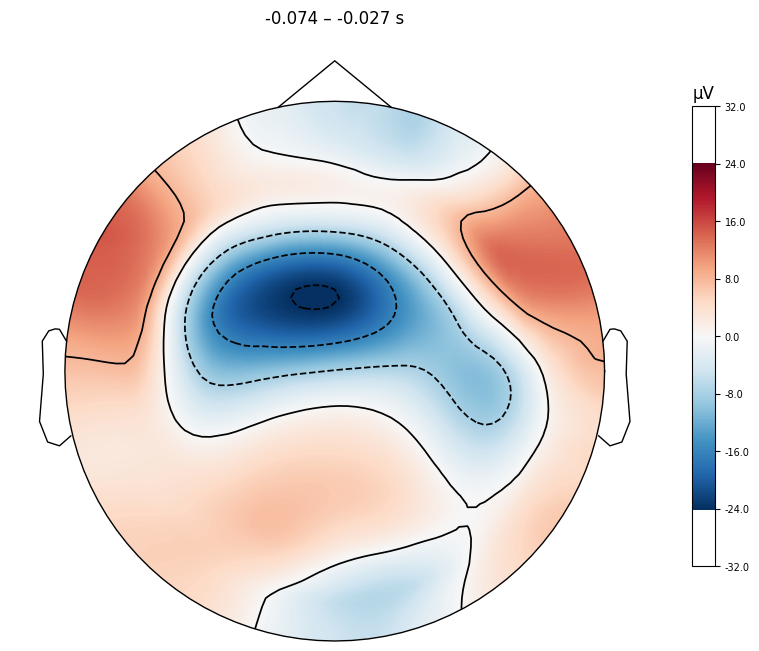

In [16]:
plt = group_RL_evoked.plot_topomap(times = [-0.05], average = 0.05, sensors = False, show_names = False, size = 5) # for selecting electrodes
fname = "/content/gdrive/MyDrive/Time_Reproduction/ERP_Plots/Topos/" + "GA_Topo_RL_elec.png"
#plt.savefig(fname, dpi = 300, bbox_inches = "tight")

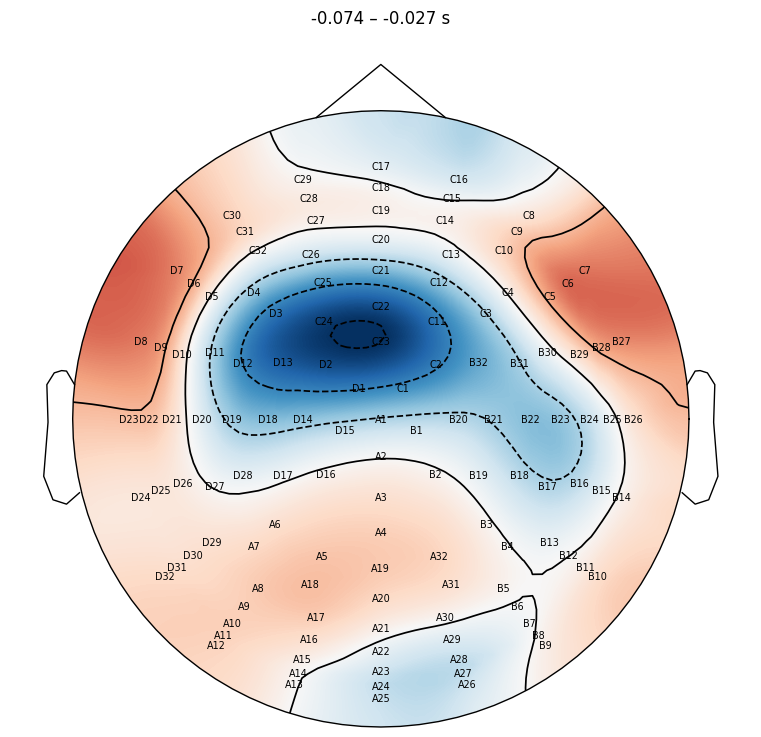

In [17]:
plt = group_RL_evoked.plot_topomap(times = [-0.05], average = 0.05, sensors = False, show_names = True, size = 5, colorbar = False) # for selecting electrodes

In [18]:
CPP_electrodes = ["A4", "A19"]
CNV_electrodes = ["C23", "C22"]

In [19]:
CNV_idx = []
for ch in CNV_electrodes:
  CNV_idx.append(group_encode_evoked.ch_names.index(ch))
print(CNV_idx)

CPP_idx = []
for ch in CPP_electrodes:
  CPP_idx.append(group_encode_evoked.ch_names.index(ch))
print(CPP_idx)

[86, 85]
[3, 18]


In [20]:
CNV_mask = np.zeros((len(group_encode_evoked.ch_names), group_RL_evoked_data.shape[1]))
CPP_mask = np.zeros((len(group_encode_evoked.ch_names), group_RL_evoked_data.shape[1]))

for ch in CNV_idx:
  CNV_mask[ch] = 1

for ch in CPP_idx:
  CPP_mask[ch] = 1

mask_params = dict(marker='o', markerfacecolor='white', markeredgecolor='white',
        linewidth=0, markersize=4)

print(CNV_mask.shape)
print(CNV_mask)

(128, 615)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


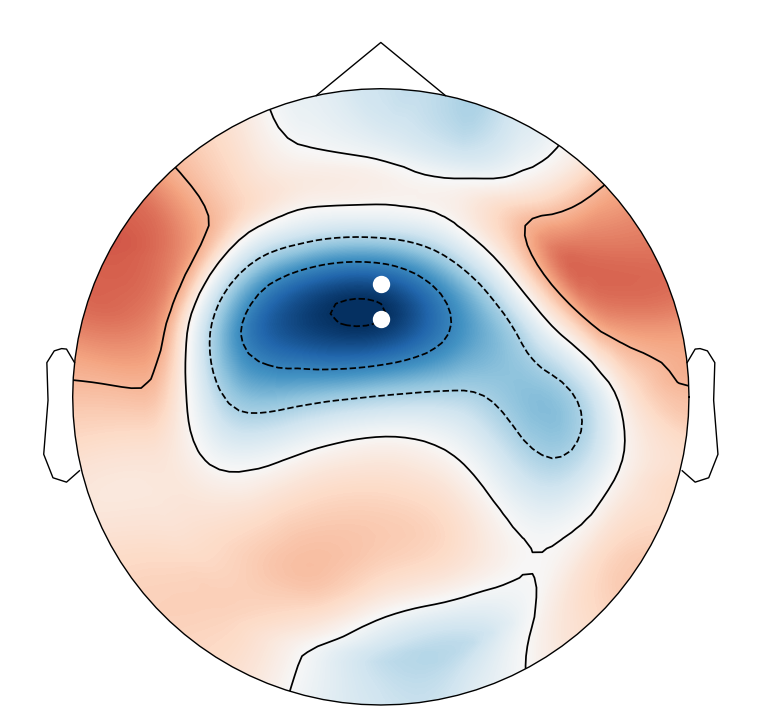

In [21]:
plt = group_RL_evoked.plot_topomap(times = [-0.05], average = 0.05, sensors = False, show_names = False, colorbar = False, size = 5, mask = CNV_mask, mask_params = mask_params,
                                   time_format = "") # for selecting electrodes
fname = "/content/gdrive/MyDrive/Time_Reproduction/ERP_Plots/Topos/" + "GA_Topo_RL_CNV.png"

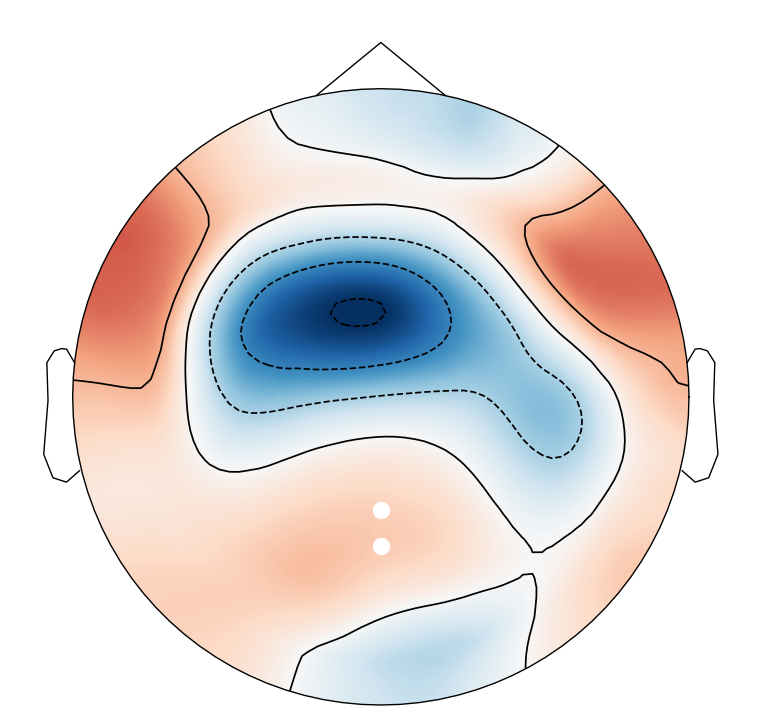

In [22]:
plt = group_RL_evoked.plot_topomap(times = [-0.05], average = 0.05, sensors = False, show_names = False, colorbar = False, size = 5, mask = CPP_mask, mask_params = mask_params,
                                   time_format = "") # for selecting electrodes
fname = "/content/gdrive/MyDrive/Time_Reproduction/ERP_Plots/Topos/" + "GA_Topo_RL_CPP.png"

# Plot Separated by Sample Interval
Separate trials by the 9 sample intervals and plot them

13/12 - removing outlier RTs when loading epochs

In [23]:
encode_SIs = np.unique(encode_metadata["Trigger"]) # SI trigger codes
print(encode_SIs)

[51 52 53 54 55 56 57 58 59]


In [24]:
encode_SIs = np.unique(encode_metadata["Trigger"]) # SI trigger codes
repo_SIs = np.unique(repo_metadata["Trigger"]) # SI trigger codes
RL_SIs = np.unique(RL_metadata["Trigger"])

n_conditions = len(encode_SIs)
all_encode_conditions = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_encode])
all_repo_conditions = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_repo])
all_RL_conditions = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_RL])

for i in range(0, len(ID_list)):
    ID = ID_list[i]

    ## Load Epochs ##
    encode_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/" + ID + "_Encode_All_CSD_epo.fif"
    repo_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/" + ID + "_Reproduction_All_CSD_epo.fif"
    RL_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/" + ID + "_RL_All_CSD_epo.fif"

    encode_epochs_participant = mne.read_epochs(encode_fname, preload = True)
    repo_epochs_participant = mne.read_epochs(repo_fname, preload = True)
    RL_epochs_participant = mne.read_epochs(RL_fname, preload = True)

    for j in range(0, n_conditions): ## Average across epochs in each condition
      encode_SI = encode_SIs[j]
      repo_SI = repo_SIs[j]
      RL_SI = RL_SIs[j]
      encode_indices = encode_epochs_participant.metadata.query("Trigger == @encode_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index # get trials for that condition
      repo_indices = repo_epochs_participant.metadata.query("Trigger == @repo_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index
      RL_indices = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index
      encode_participant_evoked = encode_epochs_participant[encode_indices].average() # average across those trials
      all_encode_conditions[i, j, :, :] = encode_participant_evoked.data
      repo_participant_evoked = repo_epochs_participant[repo_indices].average() # average across those trials
      all_repo_conditions[i, j, :, :] = repo_participant_evoked.data
      RL_participant_evoked = RL_epochs_participant[RL_indices].average() # put data in array
      all_RL_conditions[i, j, :, :] = RL_participant_evoked.data

Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P1_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
775 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P1_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P1_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 proje

In [25]:
print(all_encode_conditions.shape) # n_participants, n_sample_intervals, n_channels, n_times

(18, 9, 128, 717)


## Get Data For CPP and CNV Electrodes

In [26]:
CNV_encode_conditions = np.zeros([len(ID_list), n_conditions, n_times_encode])
CNV_repo_conditions = np.zeros([len(ID_list), n_conditions, n_times_repo])
CNV_RL_conditions = np.zeros([len(ID_list), n_conditions, n_times_RL])

for j in range(0, n_conditions):
  condition_encode =  all_encode_conditions[:, j, CNV_idx] # changed 22/08 because now doing this before averaging across participants
  condition_repo =  all_repo_conditions[:, j, CNV_idx]
  condition_RL =  all_RL_conditions[:, j, CNV_idx]
  print(condition_encode.shape)
  if condition_encode.ndim > 1:
    CNV_encode_mean = np.nanmean(condition_encode, axis = 1) # averaging activity across these electrodes
    CNV_repo_mean = np.nanmean(condition_repo, axis = 1)
    CNV_RL_mean = np.nanmean(condition_RL, axis = 1)
  else:
    CNV_encode_mean = condition_encode
    CNV_repo_mean = condition_repo
    CNV_RL_mean = condition_RL
  CNV_encode_conditions[:, j] = CNV_encode_mean * 1e6 # multiply by 1e6 to convert from volts to microvolts
  CNV_repo_conditions[:, j] = CNV_repo_mean * 1e6
  CNV_RL_conditions[:, j] = CNV_RL_mean * 1e6

(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)


In [27]:
CPP_encode_conditions = np.zeros([len(ID_list), n_conditions, n_times_encode])
CPP_repo_conditions = np.zeros([len(ID_list), n_conditions, n_times_repo])
CPP_RL_conditions = np.zeros([len(ID_list), n_conditions, n_times_RL])

for j in range(0, n_conditions):
  condition_encode =  all_encode_conditions[:, j, CPP_idx] # changed 22/08 because now doing this before averaging across participants
  condition_repo =  all_repo_conditions[:, j, CPP_idx]
  condition_RL =  all_RL_conditions[:, j, CPP_idx]
  print(condition_encode.shape)
  if condition_encode.ndim > 1:
    CPP_encode_mean = np.nanmean(condition_encode, axis = 1) # averaging activity across these electrodes
    CPP_repo_mean = np.nanmean(condition_repo, axis = 1)
    CPP_RL_mean = np.nanmean(condition_RL, axis = 1)
  else:
    CPP_encode_mean = condition_encode
    CPP_repo_mean = condition_repo
    CPP_RL_mean = condition_RL
  CPP_encode_conditions[:, j] = CPP_encode_mean * 1e6 # multiply by 1e6 to convert from volts to microvolts
  CPP_repo_conditions[:, j] = CPP_repo_mean * 1e6
  CPP_RL_conditions[:, j] = CPP_RL_mean * 1e6

(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)
(18, 2, 717)


## Average Across Participants

In [28]:
CNV_encode_conditions = np.nanmean(CNV_encode_conditions, axis = 0)
print(CNV_encode_conditions.shape)
CNV_repo_conditions = np.nanmean(CNV_repo_conditions, axis = 0)
print(CNV_repo_conditions.shape)
CNV_RL_conditions = np.nanmean(CNV_RL_conditions, axis = 0)
print(CNV_RL_conditions.shape)

CPP_encode_conditions = np.nanmean(CPP_encode_conditions, axis = 0)
print(CPP_encode_conditions.shape)
CPP_repo_conditions = np.nanmean(CPP_repo_conditions, axis = 0)
print(CPP_repo_conditions.shape)
CPP_RL_conditions = np.nanmean(CPP_RL_conditions, axis = 0)
print(CPP_RL_conditions.shape)

(9, 717)
(9, 616)
(9, 615)
(9, 717)
(9, 616)
(9, 615)


## Applying 8Hz Filter Using scipy

First define butterworth filter parameters using scipy.signal.butter

Then apply filter using scipy.signal.filtfilt

In [29]:
filter = 1
if filter == 1:

  from scipy.signal import butter

  low_pass_freq = 8

  N = 4 # order of the filter
  Wn = low_pass_freq * 2 / sample_rate # critical frequency(ies) for the filter
  b, a = butter(N, Wn)

In [30]:
if filter == 1:

  from scipy.signal import filtfilt

  for j in range(0, CPP_encode_conditions.shape[0]):
    CPP_encode_conditions[j] = filtfilt(b, a, x = CPP_encode_conditions[j])
    CPP_repo_conditions[j] = filtfilt(b, a, x = CPP_repo_conditions[j])
    CPP_RL_conditions[j] = filtfilt(b, a, x = CPP_RL_conditions[j])

## Plot

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
labels = np.arange(600, 1001, 50)

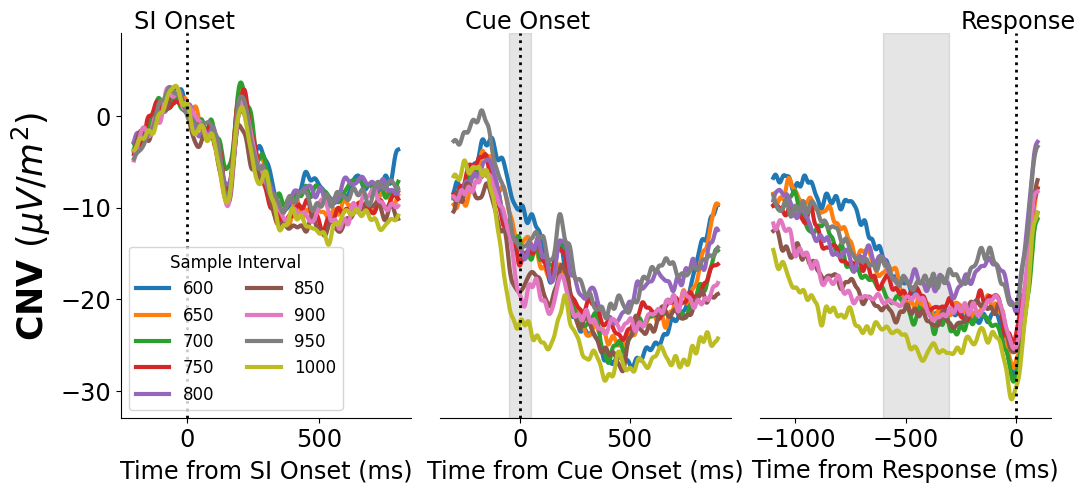

In [32]:
fig = plt.figure(figsize = (12,5))

grid = plt.GridSpec(1, 3, wspace = 0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

## Encode Plot
for j in range(0, n_conditions):
  sns.lineplot(x = encode_times_for_plot[encode_times_for_plot <= 800], y = CNV_encode_conditions[j, encode_times_for_plot <= 800], label = labels[j], linewidth = 3, ax = ax1, legend = False)

## Remove box around first plot
sns.despine(ax = ax1)

## Plot legend
ax1.legend(fontsize = "large", loc = "lower left", title = "Sample Interval", title_fontsize = "large", ncols = 2)

## Set Axes Labels and format of them
ax1.set_xlabel("Time from SI Onset (ms)", fontsize = "xx-large", labelpad = 5) # labelpad determines how far from axis the label is
ax1.set_ylabel("CNV" + " " + "$(\mu V/m^2)$", fontsize = 25, labelpad = 5, weight='bold')

## Set ylim - need to do this
ax1.set_ylim(-33, 9)

## For modifying the ticks and the tick labels
ax1.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above target onset line
ax1.text(x = -200, y = 9.5, s = "SI Onset", fontsize = "xx-large") # adjust x to move left or right

## Repo Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = repo_times_for_plot, y = CNV_repo_conditions[j], label = labels[j], linewidth = 3, ax = ax2, legend = False)

## Remove box around second plot
sns.despine(ax = ax2)

## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax2.set_xlabel("Time from Cue Onset (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax2.set_ylim(-33, 9)

## For modifying the ticks and the tick labels
ax2.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Add Mean Response Time Vertical Lines?

## Removing left spine from second plot
ax2.spines["left"].set_visible(False)
ax2.set_yticks([])

## Add shaded portion ##
b = -33
t = 9
bottom = b * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
top =  t * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
ax2.fill_between(x = repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Plotting text above target onset line
ax2.text(x = -250, y = 9.5, s = "Cue Onset", fontsize = "xx-large") # adjust x to move left or right

## RL Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = RL_times_for_plot, y = CNV_RL_conditions[j], label = labels[j], linewidth = 3, ax = ax3, legend = False)

## Remove box around second plot
sns.despine(ax = ax3)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax3.set_xlabel("Time from Response (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax3.set_ylim(-33, 9)

## For modifying the ticks and the tick labels
ax3.tick_params(labelsize = "xx-large")

## Plotting vertical dotted line response
ax3.vlines(0, ax2.get_ylim()[0], ax3.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above response line
ax3.text(x = -250, y = 9.5, s = "Response", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax3.spines["left"].set_visible(False)
ax3.set_yticks([])

## Add shaded portion ##
b = -33
t = 9
bottom = b * (np.ones(len(RL_times_for_plot[RL_slope_window_start_idx : RL_slope_window_end_idx])))
top =  t * (np.ones(len(RL_times_for_plot[RL_slope_window_start_idx : RL_slope_window_end_idx])))
ax3.fill_between(x = RL_times_for_plot[RL_slope_window_start_idx : RL_slope_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

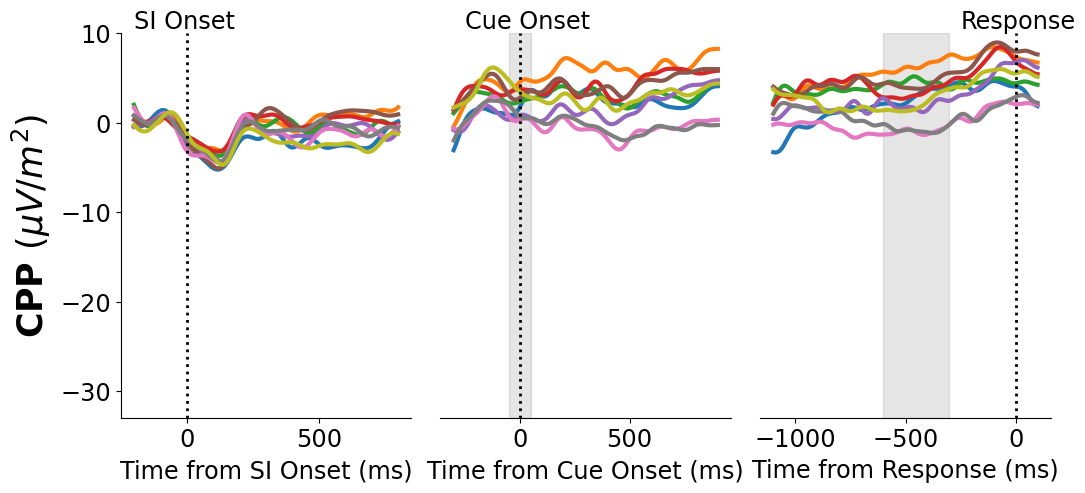

In [34]:
fig = plt.figure(figsize = (12,5))

grid = plt.GridSpec(1, 3, wspace = 0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

## Encode Plot
for j in range(0, n_conditions):
  sns.lineplot(x = encode_times_for_plot[encode_times_for_plot <= 800], y = CPP_encode_conditions[j, encode_times_for_plot <= 800], label = labels[j], linewidth = 3, ax = ax1, legend = False)

## Remove box around first plot
sns.despine(ax = ax1)

## Plot legend
#ax1.legend(fontsize = "xx-large", loc = "upper left", title = "Sample Interval Bin", title_fontsize = "xx-large")

## Set Axes Labels and format of them
ax1.set_xlabel("Time from SI Onset (ms)", fontsize = "xx-large", labelpad = 5) # labelpad determines how far from axis the label is
ax1.set_ylabel("CPP" + " " + "$(\mu V/m^2)$", fontsize = 25, labelpad = 5, weight='bold')

## Set ylim - need to do this
ax1.set_ylim(-33, 10)

## For modifying the ticks and the tick labels
ax1.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above target onset line
ax1.text(x = -200, y = 10.5, s = "SI Onset", fontsize = "xx-large") # adjust x to move left or right

## Repo Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = repo_times_for_plot, y = CPP_repo_conditions[j], label = labels[j], linewidth = 3, ax = ax2, legend = False)

## Remove box around second plot
sns.despine(ax = ax2)

## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax2.set_xlabel("Time from Cue Onset (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax2.set_ylim(-33, 10)

## For modifying the ticks and the tick labels
ax2.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Add Mean Response Time Vertical Lines?

## Add shaded portion ##
b = -33
t = 10
bottom = b * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
top =  t * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
ax2.fill_between(x = repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Removing left spine from second plot
ax2.spines["left"].set_visible(False)
ax2.set_yticks([])

## Plotting text above Cue onset line
ax2.text(x = -250, y =  10.5, s = "Cue Onset", fontsize = "xx-large") # adjust x to move left or right

## RL Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = RL_times_for_plot, y = CPP_RL_conditions[j], label = labels[j], linewidth = 3, ax = ax3, legend = False)

## Remove box around second plot
sns.despine(ax = ax3)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax3.set_xlabel("Time from Response (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax3.set_ylim(-33,  10)

## For modifying the ticks and the tick labels
ax3.tick_params(labelsize = "xx-large")

## Plotting vertical dotted line response
ax3.vlines(0, ax2.get_ylim()[0], ax3.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above response line
ax3.text(x = -250, y =  10.5, s = "Response", color = "k", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax3.spines["left"].set_visible(False)
ax3.set_yticks([])

## Add shaded portion ##
b = -33
t = 10
bottom = b * (np.ones(len(RL_times_for_plot[RL_CPP_window_start_idx : RL_CPP_window_end_idx])))
top =  t * (np.ones(len(RL_times_for_plot[RL_CPP_window_start_idx : RL_CPP_window_end_idx])))
ax3.fill_between(x = RL_times_for_plot[RL_CPP_window_start_idx : RL_CPP_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

# Plotting Separated by Sample Interval Bins
Binning Sample Intervals Into 3 Bins: Short, Intermediate, Long in order to improve the plot

In [35]:
repo_mask = 0 # determines whether you mask timepoints past responses in the repo epoch

In [36]:
encode_SIs = np.unique(encode_metadata["Trigger"]) # SI trigger codes
repo_SIs = np.unique(repo_metadata["Trigger"]) # SI trigger codes
RL_SIs = np.unique(RL_metadata["Trigger"])

n_conditions = len(encode_SIs)
all_encode_conditions_unbinned = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_encode])
all_repo_conditions_unbinned = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_repo])
all_RL_conditions_unbinned = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_RL])
median_RT_conditions_unbinned = np.zeros([len(ID_list), n_conditions])

all_encode_ses_unbinned = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_encode])
all_repo_ses_unbinned = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_repo])
all_RL_ses_unbinned = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_RL])

if repo_mask:
  pre_epoch_period =  np.abs(repo_epochs_participant.tmin)
  pre_epoch_period_samps = pre_epoch_period * 512

for i in range(0, len(ID_list)):
    ID = ID_list[i]

    ## Load Epochs ##
    encode_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/" + ID + "_Encode_All_CSD_epo.fif"
    repo_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/" + ID + "_Reproduction_All_CSD_epo.fif"
    RL_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/" + ID + "_RL_All_CSD_epo.fif"

    encode_epochs_participant = mne.read_epochs(encode_fname, preload = True)
    repo_epochs_participant = mne.read_epochs(repo_fname, preload = True)
    RL_epochs_participant = mne.read_epochs(RL_fname, preload = True)

    for j in range(0, n_conditions): ## Average across epochs in each condition
      encode_SI = encode_SIs[j]
      repo_SI = repo_SIs[j]
      RL_SI = RL_SIs[j]

      #encode_indices = encode_epochs_participant.metadata.query("Trigger == @encode_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index # get trials for that condition
      #repo_indices = repo_epochs_participant.metadata.query("Trigger == @repo_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index
      #RL_indices = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index

      encode_indices = encode_epochs_participant.metadata[(encode_epochs_participant.metadata["Trigger"] == encode_SI) & (encode_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)].index
      repo_indices = repo_epochs_participant.metadata[(repo_epochs_participant.metadata["Trigger"] == repo_SI) & (repo_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)].index
      RL_indices = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)].index

      encode_participant_evoked = encode_epochs_participant[encode_indices].average() # average across those trials
      all_encode_conditions_unbinned[i, j, :, :] = encode_participant_evoked.data
      RL_participant_evoked = RL_epochs_participant[RL_indices].average() # put data in array
      all_RL_conditions_unbinned[i, j, :, :] = RL_participant_evoked.data

      median_RT_conditions_unbinned[i, j] = repo_epochs_participant[repo_indices].metadata["Response_Time"].median()

      if repo_mask: # want to mask times that occur after the response in the repo epoch
        repo_data = repo_epochs_participant[repo_indices].get_data()
        repo_participant_metadata = repo_epochs_participant[repo_indices].metadata
        repo_data_masked = np.zeros(repo_data.shape)
        for k in range(0, repo_participant_metadata.shape[0]):
          repo_trial_data = repo_data[k]
          trial_rt_ms = repo_participant_metadata.at[repo_participant_metadata.index[k], "Response_Time"]
          trial_rt_samps = trial_rt_ms / 1000 * 512
          cutoff_point = int(pre_epoch_period_samps + trial_rt_samps)
          nan_array = np.full(repo_data[k].shape, np.NaN)
          nan_array[:, :cutoff_point] = repo_trial_data[:, :cutoff_point]
          repo_data_masked[k] = nan_array
        all_repo_conditions_unbinned[i, j, :, :] = np.nanmean(repo_data_masked, axis = 0)
      else:
        repo_participant_evoked = repo_epochs_participant[repo_indices].average() # average across those trials
        all_repo_conditions_unbinned[i, j, :, :] = repo_participant_evoked.data

Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P1_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
775 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P1_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P1_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 proje

In [37]:
print(all_encode_conditions_unbinned.shape) # n_participants, n_sample_intervals, n_channels, n_times

(18, 9, 128, 717)


## Average Sample Interval Bins Within Participant

In [38]:
n_conditions = 3
all_encode_conditions = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_encode])
all_repo_conditions = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_repo])
all_RL_conditions = np.zeros([len(ID_list), n_conditions, n_channels_evoked, n_times_RL])
median_RT_conditions = np.zeros([len(ID_list), n_conditions])

for i in range(0, len(ID_list)):
  all_encode_conditions[i, 0, :, :] = np.nanmean(all_encode_conditions_unbinned[i, 0:3, :, :], axis = 0)
  all_encode_conditions[i, 1, :, :] = np.nanmean(all_encode_conditions_unbinned[i, 3:6, :, :], axis = 0)
  all_encode_conditions[i, 2, :, :] = np.nanmean(all_encode_conditions_unbinned[i, 6:9, :, :], axis = 0)

  all_repo_conditions[i, 0, :, :] = np.nanmean(all_repo_conditions_unbinned[i, 0:3, :, :], axis = 0)
  all_repo_conditions[i, 1, :, :] = np.nanmean(all_repo_conditions_unbinned[i, 3:6, :, :], axis = 0)
  all_repo_conditions[i, 2, :, :] = np.nanmean(all_repo_conditions_unbinned[i, 6:9, :, :], axis = 0)

  all_RL_conditions[i, 0, :, :] = np.nanmean(all_RL_conditions_unbinned[i, 0:3, :, :], axis = 0)
  all_RL_conditions[i, 1, :, :] = np.nanmean(all_RL_conditions_unbinned[i, 3:6, :, :], axis = 0)
  all_RL_conditions[i, 2, :, :] = np.nanmean(all_RL_conditions_unbinned[i, 6:9, :, :], axis = 0)

  median_RT_conditions[i, 0] = np.nanmean(median_RT_conditions_unbinned[i, 0:3], axis = 0)
  median_RT_conditions[i, 1] = np.nanmean(median_RT_conditions_unbinned[i, 3:6], axis = 0)
  median_RT_conditions[i, 2] = np.nanmean(median_RT_conditions_unbinned[i, 6:9], axis = 0)

## Get Data For CPP and CNV Electrodes

In [39]:
CNV_encode_conditions = np.zeros([len(ID_list), n_conditions, n_times_encode])
CNV_repo_conditions = np.zeros([len(ID_list), n_conditions, n_times_repo])
CNV_RL_conditions = np.zeros([len(ID_list), n_conditions, n_times_RL])

for j in range(0, n_conditions):
  condition_encode =  all_encode_conditions[:, j, CNV_idx] # changed 22/08 because now doing this before averaging across participants
  condition_repo =  all_repo_conditions[:, j, CNV_idx]
  condition_RL =  all_RL_conditions[:, j, CNV_idx]
  print(condition_encode.shape)
  if condition_encode.ndim > 1:
    CNV_encode_mean = np.nanmean(condition_encode, axis = 1) # averaging activity across these electrodes
    CNV_repo_mean = np.nanmean(condition_repo, axis = 1)
    CNV_RL_mean = np.nanmean(condition_RL, axis = 1)
  else:
    CNV_encode_mean = condition_encode
    CNV_repo_mean = condition_repo
    CNV_RL_mean = condition_RL
  CNV_encode_conditions[:, j] = CNV_encode_mean * 1e6 # multiply by 1e6 to convert from volts to microvolts
  CNV_repo_conditions[:, j] = CNV_repo_mean * 1e6
  CNV_RL_conditions[:, j] = CNV_RL_mean * 1e6

(18, 2, 717)
(18, 2, 717)
(18, 2, 717)


In [40]:
CPP_encode_conditions = np.zeros([len(ID_list), n_conditions, n_times_encode])
CPP_repo_conditions = np.zeros([len(ID_list), n_conditions, n_times_repo])
CPP_RL_conditions = np.zeros([len(ID_list), n_conditions, n_times_RL])

for j in range(0, n_conditions):
  condition_encode =  all_encode_conditions[:, j, CPP_idx] # changed 22/08 because now doing this before averaging across participants
  condition_repo =  all_repo_conditions[:, j, CPP_idx]
  condition_RL =  all_RL_conditions[:, j, CPP_idx]
  print(condition_encode.shape)
  if condition_encode.ndim > 1:
    CPP_encode_mean = np.nanmean(condition_encode, axis = 1) # averaging activity across these electrodes
    CPP_repo_mean = np.nanmean(condition_repo, axis = 1)
    CPP_RL_mean = np.nanmean(condition_RL, axis = 1)
  else:
    CPP_encode_mean = condition_encode
    CPP_repo_mean = condition_repo
    CPP_RL_mean = condition_RL
  CPP_encode_conditions[:, j] = CPP_encode_mean * 1e6 # multiply by 1e6 to convert from volts to microvolts
  CPP_repo_conditions[:, j] = CPP_repo_mean * 1e6
  CPP_RL_conditions[:, j] = CPP_RL_mean * 1e6

(18, 2, 717)
(18, 2, 717)
(18, 2, 717)


## Average Across Participants

In [41]:
CNV_encode_conditions = np.nanmean(CNV_encode_conditions, axis = 0)
print(CNV_encode_conditions.shape)
CNV_repo_conditions = np.nanmean(CNV_repo_conditions, axis = 0)
print(CNV_repo_conditions.shape)
CNV_RL_conditions = np.nanmean(CNV_RL_conditions, axis = 0)
print(CNV_RL_conditions.shape)

CPP_encode_conditions = np.nanmean(CPP_encode_conditions, axis = 0)
print(CPP_encode_conditions.shape)
CPP_repo_conditions = np.nanmean(CPP_repo_conditions, axis = 0)
print(CPP_repo_conditions.shape)
CPP_RL_conditions = np.nanmean(CPP_RL_conditions, axis = 0)
print(CPP_RL_conditions.shape)

median_RT_conditions = np.nanmean(median_RT_conditions, axis = 0)
print(median_RT_conditions.shape)

(3, 717)
(3, 616)
(3, 615)
(3, 717)
(3, 616)
(3, 615)
(3,)


## Applying 8Hz Filter Using scipy

First define butterworth filter parameters using scipy.signal.butter

Then apply filter using scipy.signal.filtfilt

In [42]:
filter = 1
if filter == 1:

  from scipy.signal import butter

  low_pass_freq = 8

  N = 4 # order of the filter
  Wn = low_pass_freq * 2 / sample_rate # critical frequency(ies) for the filter
  b, a = butter(N, Wn)

In [43]:
if filter == 1:

  from scipy.signal import filtfilt

  for j in range(0, CPP_encode_conditions.shape[0]):
    CPP_encode_conditions[j] = filtfilt(b, a, x = CPP_encode_conditions[j])
    CPP_repo_conditions[j] = filtfilt(b, a, x = CPP_repo_conditions[j])
    CPP_RL_conditions[j] = filtfilt(b, a, x = CPP_RL_conditions[j])

## Plot

In [44]:
from matplotlib import pyplot as plt
%matplotlib inline
alphas = [1, 0.66, 0.33]
labels = ["Short",
          "Medium",
          "Long"]

IndexError: ignored

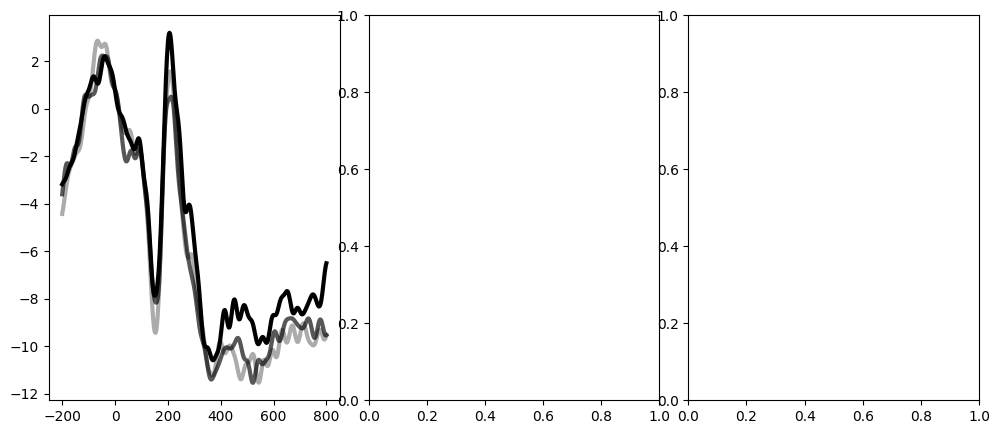

In [48]:
fig = plt.figure(figsize = (12,5))

grid = plt.GridSpec(1, 3, wspace = 0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

## Encode Plot
for j in range(0, n_conditions):
  sns.lineplot(x = encode_times_for_plot[encode_times_for_plot <= 800], y = CNV_encode_conditions[j, encode_times_for_plot <= 800], color = "k", alpha = alphas[j], label = labels[j], linewidth = 3, ax = ax1, legend = False)

## Remove box around first plot
sns.despine(ax = ax1)

## Plot legend
ax1.legend(fontsize = "xx-large", loc = "lower left", title = "Sample Interval Bin", title_fontsize = "xx-large")

## Set Axes Labels and format of them
ax1.set_xlabel("Time from SI Onset (ms)", fontsize = "xx-large", labelpad = 5) # labelpad determines how far from axis the label is
ax1.set_ylabel("CNV" + " " + "$(\mu V/m^2)$", fontsize = 25, labelpad = 5, weight='bold')

## Set ylim - need to do this
ax1.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax1.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above target onset line
ax1.text(x = -200, y = 9.5, s = "SI Onset", fontsize = "xx-large") # adjust x to move left or right

## Repo Plot ##
for j in range(0, n_conditions):
  if repo_mask:
    sns.lineplot(x = repo_times_for_plot, y = CNV_repo_conditions[j], label = labels[j], color = "k", alpha = alphas[j], linewidth = 3, ax = ax2, legend = False)
  else:
    sns.lineplot(x = repo_times_for_plot, y = CNV_repo_conditions[j], label = labels[j], color = "k", alpha = alphas[j], linewidth = 3, ax = ax2, legend = False)
  #ax2.vlines(median_RT_conditions[j], -30, 5, linestyle = "dashed", color = "k", alpha = alphas[j], linewidth = 3)

## Remove box around second plot
sns.despine(ax = ax2)

## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax2.set_xlabel("Time from Cue Onset (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax2.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax2.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Add Mean Response Time Vertical Lines?

## Removing left spine from second plot
ax2.spines["left"].set_visible(False)
ax2.set_yticks([])

## Add shaded portion ##
b = -30
t = 9
bottom = b * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
top =  t * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
ax2.fill_between(x = repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Plotting text above target onset line
ax2.text(x = -250, y = 9.5, s = "Cue Onset", fontsize = "xx-large") # adjust x to move left or right

## RL Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = RL_times_for_plot[RL_times_for_plot > (-median_RT_conditions[j])], y = CNV_RL_conditions[j, RL_times_for_plot > (-median_RT_conditions[j])], label = labels[j], color = "k", alpha = alphas[j], linewidth = 3, ax = ax3, legend = False)
  ax3.plot(RL_times_for_plot[np.where(RL_times_for_plot > (-median_RT_conditions[j]))[0][0]], CNV_RL_conditions[j, np.where(RL_times_for_plot > (-median_RT_conditions[j]))[0][0]], marker = "o", markersize = 10, markeredgecolor = "k", color = "k", alpha = alphas[j])

## Remove box around second plot
sns.despine(ax = ax3)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax3.set_xlabel("Time from Response (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax3.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax3.tick_params(labelsize = "xx-large")

## Plotting vertical dotted line response
ax3.vlines(0, ax2.get_ylim()[0], ax3.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above response line
ax3.text(x = -250, y = 9.5, s = "Response", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax3.spines["left"].set_visible(False)
ax3.set_yticks([])

## Add shaded portion ##
b = -30
t = 9
bottom = b * (np.ones(len(RL_times_for_plot[RL_slope_window_start_idx : RL_slope_window_end_idx])))
top =  t * (np.ones(len(RL_times_for_plot[RL_slope_window_start_idx : RL_slope_window_end_idx])))
ax3.fill_between(x = RL_times_for_plot[RL_slope_window_start_idx : RL_slope_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Saving
if repo_mask:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "CNV_Sample_Interval_Bins_Repo_Masked.png"
else:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "CNV_Sample_Interval_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [ ]:
fig = plt.figure(figsize = (12,5))

grid = plt.GridSpec(1, 3, wspace = 0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

## Encode Plot
for j in range(0, n_conditions):
  sns.lineplot(x = encode_times_for_plot[encode_times_for_plot <= 800], y = CPP_encode_conditions[j, encode_times_for_plot <= 800], color = "k", alpha = alphas[j], label = labels[j], linewidth = 3, ax = ax1, legend = False)

## Remove box around first plot
sns.despine(ax = ax1)

## Plot legend
#ax1.legend(fontsize = "xx-large", loc = "upper left", title = "Sample Interval Bin", title_fontsize = "xx-large")

## Set Axes Labels and format of them
ax1.set_xlabel("Time from SI Onset (ms)", fontsize = "xx-large", labelpad = 5) # labelpad determines how far from axis the label is
ax1.set_ylabel("CPP" + " " + "$(\mu V/m^2)$", fontsize = 25, labelpad = 5, weight='bold')

## Set ylim - need to do this
ax1.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax1.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above target onset line
ax1.text(x = -200, y = 9.5, s = "SI Onset", fontsize = "xx-large") # adjust x to move left or right

## Repo Plot ##
for j in range(0, n_conditions):
  if repo_mask:
    sns.lineplot(x = repo_times_for_plot, y = CPP_repo_conditions[j], label = labels[j], color = "k", alpha = alphas[j], linewidth = 3, ax = ax2, legend = False)
  else:
    sns.lineplot(x = repo_times_for_plot, y = CPP_repo_conditions[j], label = labels[j], color = "k", alpha = alphas[j], linewidth = 3, ax = ax2, legend = False)

## Remove box around second plot
sns.despine(ax = ax2)

## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax2.set_xlabel("Time from Cue Onset (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax2.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax2.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Add Mean Response Time Vertical Lines?

## Add shaded portion ##
b = -30
t = 9
bottom = b * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
top =  t * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
ax2.fill_between(x = repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Removing left spine from second plot
ax2.spines["left"].set_visible(False)
ax2.set_yticks([])

## Plotting text above Cue onset line
ax2.text(x = -250, y = 9.5, s = "Cue Onset", fontsize = "xx-large") # adjust x to move left or right

## RL Plot ##
for j in range(0, n_conditions):
  sns.lineplot(x = RL_times_for_plot[RL_times_for_plot > (-median_RT_conditions[j])], y = CPP_RL_conditions[j, RL_times_for_plot > (-median_RT_conditions[j])], label = labels[j], color = "k", alpha = alphas[j], linewidth = 3, ax = ax3, legend = False)
  ax3.plot(RL_times_for_plot[np.where(RL_times_for_plot > (-median_RT_conditions[j]))[0][0]], CPP_RL_conditions[j, np.where(RL_times_for_plot > (-median_RT_conditions[j]))[0][0]], marker = "o", markersize = 10, markeredgecolor = "k", color = "k", alpha = alphas[j])

## Remove box around second plot
sns.despine(ax = ax3)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax3.set_xlabel("Time from Response (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax3.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax3.tick_params(labelsize = "xx-large")

## Plotting vertical dotted line response
ax3.vlines(0, ax2.get_ylim()[0], ax3.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above response line
ax3.text(x = -250, y = 9.5, s = "Response", color = "k", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax3.spines["left"].set_visible(False)
ax3.set_yticks([])

## Add shaded portion ##
b = -30
t = 9
bottom = b * (np.ones(len(RL_times_for_plot[RL_CPP_window_start_idx : RL_CPP_window_end_idx])))
top =  t * (np.ones(len(RL_times_for_plot[RL_CPP_window_start_idx : RL_CPP_window_end_idx])))
ax3.fill_between(x = RL_times_for_plot[RL_CPP_window_start_idx : RL_CPP_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Saving
if repo_mask:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "CPP_Sample_Interval_Bins_Repo_Masked.png"
else:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "CPP_Sample_Interval_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

# Plot separated by RT bins
Done within sample interval to control for effect of sample interval

In [49]:
n_bins = 2
n_conditions = len(encode_SIs)
all_encode_conditions_SI = np.zeros([len(ID_list), n_conditions, n_bins, n_channels_evoked, n_times_encode])
all_repo_conditions_SI = np.zeros([len(ID_list), n_conditions, n_bins, n_channels_evoked, n_times_repo])
all_RL_conditions_SI = np.zeros([len(ID_list), n_conditions, n_bins, n_channels_evoked, n_times_RL])

encode_ntrials = np.zeros([len(ID_list), n_conditions, n_bins])
repo_ntrials = np.zeros([len(ID_list), n_conditions, n_bins])
RL_ntrials = np.zeros([len(ID_list), n_conditions, n_bins])

median_RT = np.zeros([len(ID_list), n_conditions, n_bins])

for i in range(0, len(ID_list)):
    ID = ID_list[i]
    print(ID)

    ## Load Epochs ##
    encode_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/" + ID + "_Encode_All_CSD_epo.fif"
    repo_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/" + ID + "_Reproduction_All_CSD_epo.fif"
    RL_fname = "/content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/" + ID + "_RL_All_CSD_epo.fif"

    encode_epochs_participant = mne.read_epochs(encode_fname, preload = True)
    repo_epochs_participant = mne.read_epochs(repo_fname, preload = True)
    RL_epochs_participant = mne.read_epochs(RL_fname, preload = True)

    for j in range(0, n_conditions): ## Iterate through
      encode_SI = encode_SIs[j]
      repo_SI = repo_SIs[j]
      RL_SI = RL_SIs[j]

      ## Getting Median For Each Type of Epoch
      #encode_indices_metadata = encode_epochs_participant.metadata.query("Trigger == @encode_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
      encode_indices_metadata = encode_epochs_participant.metadata[(encode_epochs_participant.metadata["Trigger"] == encode_SI) & (encode_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)]
      encode_median = encode_indices_metadata["Response_Time"].median()
      #repo_indices_metadata = repo_epochs_participant.metadata.query("Trigger == @repo_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
      repo_indices_metadata = repo_epochs_participant.metadata[(repo_epochs_participant.metadata["Trigger"] == repo_SI) & (repo_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)]
      repo_median = repo_indices_metadata["Response_Time"].median()
      #RL_indices_metadata = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
      RL_indices_metadata = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff)]
      RL_median = RL_indices_metadata["Response_Time"].median()

      ## Getting Trials Above and Below the Median
      # Above
      #encode_above_indices = encode_epochs_participant.metadata.query("Trigger == @encode_SI & Response_Time > @encode_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index # get trials for that condition
      #repo_above_indices = repo_epochs_participant.metadata.query("Trigger == @repo_SI & Response_Time > @repo_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index
      #RL_above_indices = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time > @RL_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index

      encode_above_indices = encode_epochs_participant.metadata[(encode_epochs_participant.metadata["Trigger"] == encode_SI) & (encode_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] > encode_median)].index
      repo_above_indices = repo_epochs_participant.metadata[(repo_epochs_participant.metadata["Trigger"] == repo_SI) & (repo_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] > repo_median)].index
      RL_above_indices = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] > RL_median)].index

      encode_ntrials[i, j, 0] = len(encode_above_indices)
      repo_ntrials[i, j, 0] = len(repo_above_indices)
      RL_ntrials[i, j, 0] = len(RL_above_indices)
      #mean_RT_metadata = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time > @RL_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
      median_RT_metadata = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] > RL_median)]
      median_RT[i, j, 0] = median_RT_metadata["Response_Time"].median()
      encode_above_participant_evoked = encode_epochs_participant[encode_above_indices].average() # average across those trials
      all_encode_conditions_SI[i, j, 0, :, :] = encode_above_participant_evoked.data
      RL_above_participant_evoked = RL_epochs_participant[RL_above_indices].average() # put data in array
      all_RL_conditions_SI[i, j, 0, :, :] = RL_above_participant_evoked.data
      if repo_mask:
        repo_data = repo_epochs_participant[repo_above_indices].get_data()
        repo_participant_metadata = repo_epochs_participant[repo_above_indices].metadata
        repo_data_masked = np.zeros(repo_data.shape)
        for k in range(0, repo_participant_metadata.shape[0]):
          repo_trial_data = repo_data[k]
          trial_rt_ms = repo_participant_metadata.at[repo_participant_metadata.index[k], "Response_Time"]
          trial_rt_samps = trial_rt_ms / 1000 * 512
          cutoff_point = int(pre_epoch_period_samps + trial_rt_samps)
          nan_array = np.full(repo_data[k].shape, np.NaN)
          nan_array[:, :cutoff_point] = repo_trial_data[:, :cutoff_point]
          repo_data_masked[k] = nan_array
          all_repo_conditions_SI[i, j, 0, :, :] = np.nanmean(repo_data_masked, axis = 0)
      else:
        repo_above_participant_evoked = repo_epochs_participant[repo_above_indices].average() # average across those trials
        all_repo_conditions_SI[i, j, 0, :, :] = repo_above_participant_evoked.data

      # Below
      #encode_below_indices = encode_epochs_participant.metadata.query("Trigger == @encode_SI & Response_Time < @encode_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index # get trials for that condition
      #repo_below_indices = repo_epochs_participant.metadata.query("Trigger == @repo_SI & Response_Time < @repo_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index
      #RL_below_indices = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time < @RL_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff").index

      encode_below_indices = encode_epochs_participant.metadata[(encode_epochs_participant.metadata["Trigger"] == encode_SI) & (encode_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (encode_epochs_participant.metadata["Response_Time"] < encode_median)].index
      repo_below_indices = repo_epochs_participant.metadata[(repo_epochs_participant.metadata["Trigger"] == repo_SI) & (repo_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (repo_epochs_participant.metadata["Response_Time"] < repo_median)].index
      RL_below_indices = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < RL_median)].index

      encode_ntrials[i, j, 1] = len(encode_below_indices)
      repo_ntrials[i, j, 1] = len(repo_below_indices)
      RL_ntrials[i, j, 1] = len(RL_below_indices)
      #mean_RT_metadata = RL_epochs_participant.metadata.query("Trigger == @RL_SI & Response_Time < @RL_median & Response_Time > @lower_RT_cutoff & Response_Time < @upper_RT_cutoff")
      median_RT_metadata = RL_epochs_participant.metadata[(RL_epochs_participant.metadata["Trigger"] == RL_SI) & (RL_epochs_participant.metadata["Response_Time"] > lower_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < upper_RT_cutoff) & (RL_epochs_participant.metadata["Response_Time"] < RL_median)]

      median_RT[i, j, 1] = median_RT_metadata["Response_Time"].median()
      encode_below_participant_evoked = encode_epochs_participant[encode_below_indices].average() # average across those trials
      all_encode_conditions_SI[i, j, 1, :, :] = encode_below_participant_evoked.data
      RL_below_participant_evoked = RL_epochs_participant[RL_below_indices].average() # put data in array
      all_RL_conditions_SI[i, j, 1, :, :] = RL_below_participant_evoked.data
      if repo_mask:
        repo_data = repo_epochs_participant[repo_below_indices].get_data()
        repo_participant_metadata = repo_epochs_participant[repo_below_indices].metadata
        repo_data_masked = np.zeros(repo_data.shape)
        for k in range(0, repo_participant_metadata.shape[0]):
          repo_trial_data = repo_data[k]
          trial_rt_ms = repo_participant_metadata.at[repo_participant_metadata.index[k], "Response_Time"]
          trial_rt_samps = trial_rt_ms / 1000 * 512
          cutoff_point = int(pre_epoch_period_samps + trial_rt_samps)
          nan_array = np.full(repo_data[k].shape, np.NaN)
          nan_array[:, :cutoff_point] = repo_trial_data[:, :cutoff_point]
          repo_data_masked[k] = nan_array
          all_repo_conditions_SI[i, j, 1, :, :] = np.nanmean(repo_data_masked, axis = 0)
      else:
        repo_below_participant_evoked = repo_epochs_participant[repo_below_indices].average() # average across those trials
        all_repo_conditions_SI[i, j, 1, :, :] = repo_below_participant_evoked.data

P1
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Encode/P1_Encode_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...    1199.22 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
775 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Reproduction/P1_Reproduction_All_CSD_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     900.39 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 projection items activated
Reading /content/gdrive/MyDrive/Time_Reproduction/Epochs_CSD/Response_Locked/P1_RL_All_CSD_epo.fif ...
    Found the data of interest:
        t =   -1099.61 ...      99.61 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
762 matching events found
No baseline correction applied
0 pr

## Average Across Sample Intervals
Averaging bins across sample intervals now to get RT bins that are separate from sample interval

In [50]:
all_encode_conditions = np.zeros([len(ID_list), n_bins, n_channels_evoked, n_times_encode])
all_repo_conditions = np.zeros([len(ID_list), n_bins, n_channels_evoked, n_times_repo])
all_RL_conditions = np.zeros([len(ID_list), n_bins, n_channels_evoked, n_times_RL])
median_RT_conditions = np.zeros([len(ID_list), n_bins])

for i in range(0, len(ID_list)):

    for k in range(0, n_bins):
      all_encode_conditions[i, k] = np.nanmean(all_encode_conditions_SI[i, :, k], axis = 0)
      all_repo_conditions[i, k] = np.nanmean(all_repo_conditions_SI[i, :, k], axis = 0)
      all_RL_conditions[i, k] = np.nanmean(all_RL_conditions_SI[i, :, k], axis = 0)
      median_RT_conditions[i, k] = np.nanmean(median_RT[i, :, k], axis = 0)

print(median_RT_conditions.shape)

(18, 2)


## Get Data For CPP and CNV Electrodes

In [51]:
CNV_encode_conditions = np.zeros([len(ID_list), n_bins, n_times_encode])
CNV_repo_conditions = np.zeros([len(ID_list), n_bins, n_times_repo])
CNV_RL_conditions = np.zeros([len(ID_list), n_bins, n_times_RL])

for j in range(0, n_bins):
  condition_encode =  all_encode_conditions[:, j, CNV_idx] # changed 22/08 because now doing this before averaging across participants
  condition_repo =  all_repo_conditions[:, j, CNV_idx]
  condition_RL =  all_RL_conditions[:, j, CNV_idx]
  print(condition_encode.shape)
  if condition_encode.ndim > 1:
    CNV_encode_mean = np.nanmean(condition_encode, axis = 1) # averaging activity across these electrodes
    CNV_repo_mean = np.nanmean(condition_repo, axis = 1)
    CNV_RL_mean = np.nanmean(condition_RL, axis = 1)
  else:
    CNV_encode_mean = condition_encode
    CNV_repo_mean = condition_repo
    CNV_RL_mean = condition_RL
  CNV_encode_conditions[:, j] = CNV_encode_mean * 1e6 # multiply by 1e6 to convert from volts to microvolts
  CNV_repo_conditions[:, j] = CNV_repo_mean * 1e6
  CNV_RL_conditions[:, j] = CNV_RL_mean * 1e6

(18, 2, 717)
(18, 2, 717)


In [52]:
CPP_encode_conditions = np.zeros([len(ID_list), n_bins, n_times_encode])
CPP_repo_conditions = np.zeros([len(ID_list), n_bins, n_times_repo])
CPP_RL_conditions = np.zeros([len(ID_list), n_bins, n_times_RL])

for j in range(0, n_bins):
  condition_encode =  all_encode_conditions[:, j, CPP_idx] # changed 22/08 because now doing this before averaging across participants
  condition_repo =  all_repo_conditions[:, j, CPP_idx]
  condition_RL =  all_RL_conditions[:, j, CPP_idx]
  print(condition_encode.shape)
  if condition_encode.ndim > 1:
    CPP_encode_mean = np.nanmean(condition_encode, axis = 1) # averaging activity across these electrodes
    CPP_repo_mean = np.nanmean(condition_repo, axis = 1)
    CPP_RL_mean = np.nanmean(condition_RL, axis = 1)
  else:
    CPP_encode_mean = condition_encode
    CPP_repo_mean = condition_repo
    CPP_RL_mean = condition_RL
  CPP_encode_conditions[:, j] = CPP_encode_mean * 1e6 # multiply by 1e6 to convert from volts to microvolts
  CPP_repo_conditions[:, j] = CPP_repo_mean * 1e6
  CPP_RL_conditions[:, j] = CPP_RL_mean * 1e6

(18, 2, 717)
(18, 2, 717)


## Average Across Participants

In [53]:
CNV_encode_conditions = np.nanmean(CNV_encode_conditions, axis = 0)
print(CNV_encode_conditions.shape)
CNV_repo_conditions = np.nanmean(CNV_repo_conditions, axis = 0)
print(CNV_repo_conditions.shape)
CNV_RL_conditions = np.nanmean(CNV_RL_conditions, axis = 0)
print(CNV_RL_conditions.shape)

CPP_encode_conditions = np.nanmean(CPP_encode_conditions, axis = 0)
print(CPP_encode_conditions.shape)
CPP_repo_conditions = np.nanmean(CPP_repo_conditions, axis = 0)
print(CPP_repo_conditions.shape)
CPP_RL_conditions = np.nanmean(CPP_RL_conditions, axis = 0)
print(CPP_RL_conditions.shape)

median_RT_conditions = np.nanmean(median_RT_conditions, axis = 0)
print(median_RT_conditions.shape)

(2, 717)
(2, 616)
(2, 615)
(2, 717)
(2, 616)
(2, 615)
(2,)


## Applying 8Hz Filter Using scipy

First define butterworth filter parameters using scipy.signal.butter

Then apply filter using scipy.signal.filtfilt

In [54]:
filter = 1
if filter == 1:

  from scipy.signal import butter

  low_pass_freq = 8

  N = 4 # order of the filter
  Wn = low_pass_freq * 2 / sample_rate # critical frequency(ies) for the filter
  b, a = butter(N, Wn)

In [55]:
if filter == 1:

  from scipy.signal import filtfilt

  for j in range(0, CPP_encode_conditions.shape[0]):
    CPP_encode_conditions[j] = filtfilt(b, a, x = CPP_encode_conditions[j])
    CPP_repo_conditions[j] = filtfilt(b, a, x = CPP_repo_conditions[j])
    CPP_RL_conditions[j] = filtfilt(b, a, x = CPP_RL_conditions[j])

## Plot

In [56]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("default")
labels = ["Slower", "Faster"]
colors = ["blue", "red"]

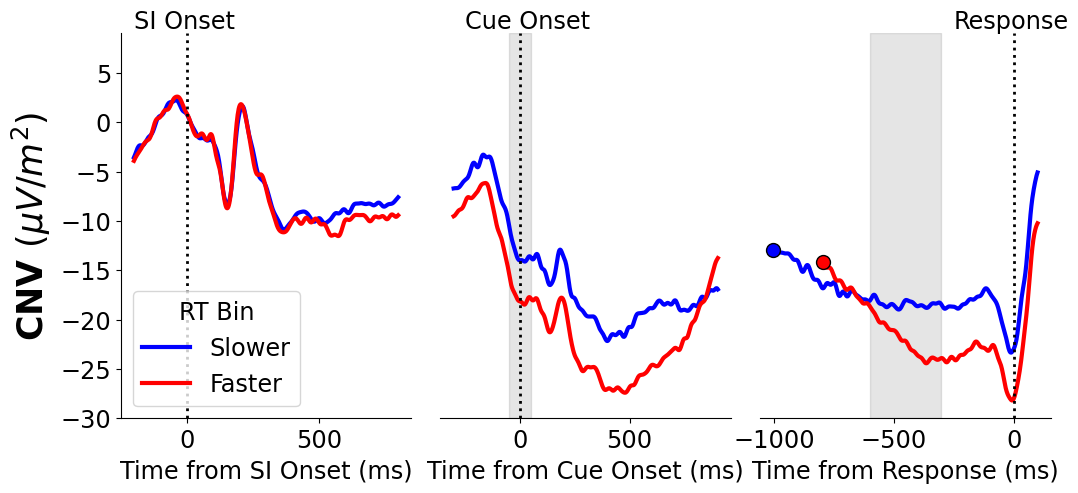

In [57]:
fig = plt.figure(figsize = (12,5))

grid = plt.GridSpec(1, 3, wspace = 0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

## Encode Plot
for j in range(0, n_bins):
    sns.lineplot(x = encode_times_for_plot[encode_times_for_plot <= 800], y = CNV_encode_conditions[j, encode_times_for_plot <= 800], color = colors[j], label = labels[j], linewidth = 3, ax = ax1, legend = False)

## Remove box around first plot
sns.despine(ax = ax1)

## Plot legend
ax1.legend(fontsize = "xx-large", loc = "lower left", title = "RT Bin", title_fontsize = "xx-large")

## Set Axes Labels and format of them
ax1.set_xlabel("Time from SI Onset (ms)", fontsize = "xx-large", labelpad = 5) # labelpad determines how far from axis the label is
ax1.set_ylabel("CNV" + " " + "$(\mu V/m^2)$", fontsize = 25, labelpad = 5, weight='bold')

## Set ylim - need to do this
ax1.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax1.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above target onset line
ax1.text(x = -200, y = 9.5, s = "SI Onset", fontsize = "xx-large") # adjust x to move left or right

## Repo Plot ##
for j in range(0, n_bins):
  if repo_mask:
    sns.lineplot(x = repo_times_for_plot, y = CNV_repo_conditions[j], label = labels[j], color = colors[j], linewidth = 3, ax = ax2, legend = False)
  else:
    sns.lineplot(x = repo_times_for_plot, y = CNV_repo_conditions[j], label = labels[j], color = colors[j], linewidth = 3, ax = ax2, legend = False)

## Remove box around second plot
sns.despine(ax = ax2)

## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax2.set_xlabel("Time from Cue Onset (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax2.set_ylim(-30, 9)

## Add shaded portion ##
b = -30
t = 9
bottom = b * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
top =  t * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
ax2.fill_between(x = repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## For modifying the ticks and the tick labels
ax2.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of cue onset
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above cue onset line
ax2.text(x =  -250, y = 9.5, s = "Cue Onset", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax2.spines["left"].set_visible(False)
ax2.set_yticks([])

## RL Plot ##
for j in range(0, n_bins):
  sns.lineplot(x = RL_times_for_plot[RL_times_for_plot > (-median_RT_conditions[j])], y = CNV_RL_conditions[j, RL_times_for_plot > (-median_RT_conditions[j])], label = labels[j], color = colors[j], linewidth = 3, ax = ax3, legend = False)
  ax3.plot(RL_times_for_plot[np.where(RL_times_for_plot > (-median_RT_conditions[j]))[0][0]], CNV_RL_conditions[j, np.where(RL_times_for_plot > (-median_RT_conditions[j]))[0][0]], marker = "o", markersize = 10, markeredgecolor = "k", color = colors[j])

## Remove box around second plot
sns.despine(ax = ax3)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax3.set_xlabel("Time from Response (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax3.set_ylim(-30, 9)

## Add shaded portion ##
b = -30
t = 9
bottom = b * (np.ones(len(RL_times_for_plot[RL_slope_window_start_idx : RL_slope_window_end_idx])))
top =  t * (np.ones(len(RL_times_for_plot[RL_slope_window_start_idx : RL_slope_window_end_idx])))
ax3.fill_between(x = RL_times_for_plot[RL_slope_window_start_idx : RL_slope_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## For modifying the ticks and the tick labels
ax3.tick_params(labelsize = "xx-large")

## Plotting vertical dotted line response
ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above response line
ax3.text(x = -250, y = 9.5, s = "Response", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax3.spines["left"].set_visible(False)
ax3.set_yticks([])

## Saving
if repo_mask:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "CNV_Over_Under_Bins_Repo_Masked.png"
else:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "CNV_Over_Under_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

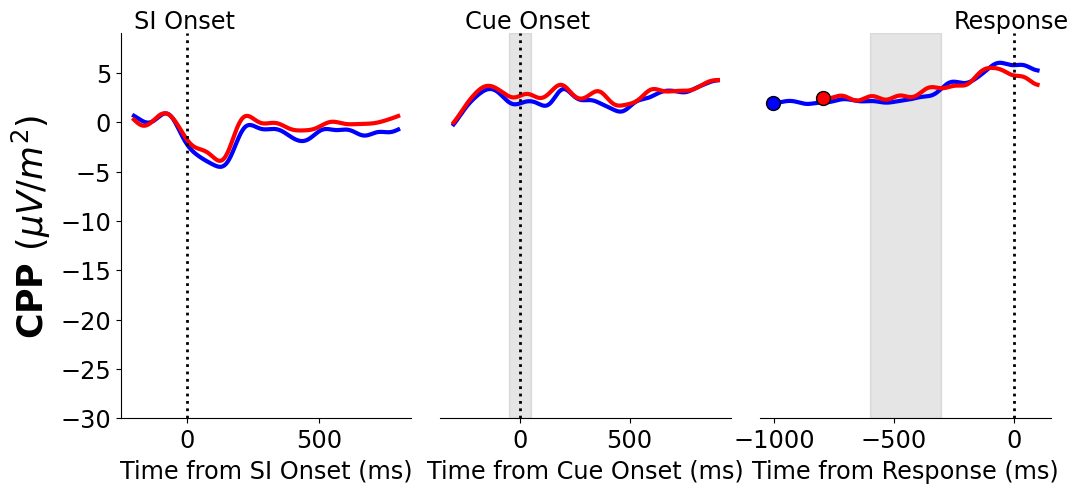

In [58]:
fig = plt.figure(figsize = (12,5))

grid = plt.GridSpec(1, 3, wspace = 0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

## Encode Plot
for j in range(0, n_bins):
  sns.lineplot(x = encode_times_for_plot[encode_times_for_plot <= 800], y = CPP_encode_conditions[j, encode_times_for_plot <= 800], color = colors[j], label = labels[j], linewidth = 3, ax = ax1, legend = False)

## Remove box around first plot
sns.despine(ax = ax1)

## Plot legend
#ax1.legend(fontsize = "xx-large", loc = "upper left", title = "RT Bin", title_fontsize = "xx-large")

## Set Axes Labels and format of them
ax1.set_xlabel("Time from SI Onset (ms)", fontsize = "xx-large", labelpad = 5) # labelpad determines how far from axis the label is
ax1.set_ylabel("CPP" + " " + "$(\mu V/m^2)$", fontsize = 25, labelpad = 5, weight='bold')

## Set ylim - need to do this
ax1.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax1.tick_params(labelsize = "xx-large")

## Plotting vertical line at time of target onset
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above target onset line
ax1.text(x = -200, y = 9.5, s = "SI Onset", fontsize = "xx-large") # adjust x to move left or right

## Repo Plot ##
for j in range(0, n_bins):
  sns.lineplot(x = repo_times_for_plot, y = CPP_repo_conditions[j], label = labels[j], color = colors[j], linewidth = 3, ax = ax2, legend = False)

## Remove box around second plot
sns.despine(ax = ax2)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax2.set_xlabel("Time from Cue Onset (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax2.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax2.tick_params(labelsize = "xx-large")

## Removing left spine from second plot
ax2.spines["left"].set_visible(False)
ax2.set_yticks([])

## Plotting vertical line at time of cue onset
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Add shaded portion ##
b = -30
t = 9
bottom = b * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
top =  t * (np.ones(len(repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx])))
ax2.fill_between(x = repo_times_for_plot[repo_amplitude_window_start_idx : repo_amplitude_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Plotting text above cue onset line
ax2.text(x = -250, y = 9.5, s = "Cue Onset", fontsize = "xx-large") # adjust x to move left or right

for j in range(0, n_bins):
  sns.lineplot(x = RL_times_for_plot[RL_times_for_plot > (-median_RT_conditions[j])], y = CPP_RL_conditions[j, RL_times_for_plot > (-median_RT_conditions[j])], label = labels[j], color = colors[j], linewidth = 3, ax = ax3, legend = False)
  ax3.plot(RL_times_for_plot[np.where(RL_times_for_plot > (-median_RT_conditions[j]))[0][0]], CPP_RL_conditions[j, np.where(RL_times_for_plot > (-median_RT_conditions[j]))[0][0]], marker = "o", markersize = 10, markeredgecolor = "k", color = colors[j])

## Remove box around second plot
sns.despine(ax = ax3)
## Set Axes Labels and format of them - decided not to plot y axis label on second plot
ax3.set_xlabel("Time from Response (ms)", fontsize = "xx-large", labelpad = 5)

## Set ylim - need to do this manually for maximum customisation
ax3.set_ylim(-30, 9)

## For modifying the ticks and the tick labels
ax3.tick_params(labelsize = "xx-large")

## Plotting vertical dotted line response
ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color = "k", linestyle = "dotted", linewidth = 2)

## Plotting text above response line
ax3.text(x = -250, y = 9.5, s = "Response", fontsize = "xx-large") # adjust x to move left or right

## Removing left spine from second plot
ax3.spines["left"].set_visible(False)
ax3.set_yticks([])

## Add shaded portion ##
b = -30
t = 9
bottom = b * (np.ones(len(RL_times_for_plot[RL_CPP_window_start_idx : RL_CPP_window_end_idx])))
top =  t * (np.ones(len(RL_times_for_plot[RL_CPP_window_start_idx : RL_CPP_window_end_idx])))
ax3.fill_between(x = RL_times_for_plot[RL_CPP_window_start_idx : RL_CPP_window_end_idx], y1 = bottom, y2 = top, color = "black", alpha = 0.1)

## Saving
if repo_mask:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "CPP_Over_Under_Bins_Repo_Masked.png"
else:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/ERPs/" + "CPP_Over_Under_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")